Time Series Anomaly Detection using LSTM Autoencoders

The project detects anomalies in time seies ECG signal data.

The dataset consists of 5000 time series examples with 140 timesteps. Each sequence corresponds to a single heartbeat recorded from a single patient.The patient has severe congestive heart failure.

There are 5 classes of heartbeat: Normal, R-on-T PVC, PVC, SP, UB


In [1]:
from scipy.io import arff
import pandas as pd

In [2]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F

C:\Users\user\AppData\Roaming\Python\Python312\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [8]:
from sklearn.preprocessing import LabelEncoder

In [10]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [11]:
# Load the ARFF file
data, meta = arff.loadarff('/content/drive/MyDrive/ECG5000/ECG5000_TRAIN.arff')

# Convert to a pandas DataFrame
df_train = pd.DataFrame(data)



print(df_train.head())

       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.2

In [12]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,b'1'
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,b'1'
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,b'1'
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,b'1'
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,b'1'


In [13]:
df_train['target'].dtype

dtype('O')

In [14]:
df_train['target'].unique()

array([b'1', b'2', b'3', b'4', b'5'], dtype=object)

In [15]:
df_train['target'] = df_train['target'].str.decode('utf-8')

In [16]:
label_encoder = LabelEncoder()
df_train['target'] = label_encoder.fit_transform(df_train['target'])+1

In [17]:
print(df_train['target'].unique())

[1 2 3 4 5]


In [18]:
df_train.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [19]:
data, meta = arff.loadarff('/content/drive/MyDrive/ECG5000/ECG5000_TEST.arff')

# Convert to a pandas DataFrame
df_test = pd.DataFrame(data)





In [20]:
df_test.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,b'1'
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,b'1'
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,b'1'
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,b'1'
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,b'1'


In [21]:
df_test['target'].unique()

array([b'1', b'2', b'3', b'4', b'5'], dtype=object)

In [33]:
df_train['target'].unique()

array([1, 2, 3, 4, 5])

In [22]:
df_test['target'] = df_test['target'].str.decode('utf-8')
label_encoder = LabelEncoder()
df_test['target'] = label_encoder.fit_transform(df_test['target'])+1

In [23]:
df_test['target'].unique()

array([1, 2, 3, 4, 5])

In [24]:
df_test.shape

(4500, 141)

In [25]:
df_train.shape

(500, 141)

In [26]:
df= pd.concat([df_train, df_test], ignore_index=True)

In [27]:
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [51]:
df.sample(10)

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1728,-1.101625,-2.402245,-3.098415,-3.565321,-3.894319,-3.780759,-3.427032,-2.303533,-1.534961,-1.408406,...,1.556053,1.259763,0.730135,0.073590,-0.518567,-0.969860,-0.968947,-0.431241,-0.744742,1
1752,-2.413868,-3.351679,-3.496330,-3.862014,-3.600662,-3.205135,-2.265680,-1.424750,-1.273709,-0.949210,...,0.664899,0.096601,-0.355199,-0.682083,-0.655125,-0.282382,-0.239298,-0.926814,-2.111372,1
2519,-1.644921,-2.409708,-3.279804,-3.825820,-4.099372,-3.825975,-3.345044,-2.272802,-1.737734,-1.522103,...,0.942096,0.988068,0.773729,0.361819,-0.040981,-0.122264,0.171462,-0.151763,-0.918836,1
2599,-1.071345,-3.057208,-3.528616,-4.049366,-3.968148,-3.391407,-2.576679,-1.361591,-0.710019,-0.417656,...,1.178757,0.858046,0.079202,-0.647964,-1.390050,-1.674802,-1.670535,-1.323539,-2.637817,1
448,-0.276243,-1.305506,-2.001637,-2.805250,-2.921178,-2.782342,-2.400933,-1.917501,-1.274907,-0.812966,...,-1.461149,-1.864227,-2.352797,-2.824019,-3.185046,-3.865289,-3.337587,-2.820927,-1.120418,2
3882,-0.627417,-1.792091,-2.632488,-3.122699,-3.062360,-2.838146,-2.398149,-1.760431,-1.132024,-0.735427,...,-2.173328,-2.686076,-3.275976,-3.681385,-3.453702,-2.787546,-1.653968,-0.514923,0.326273,2
1325,1.056420,-1.470053,-3.125910,-3.601408,-3.466305,-3.142460,-2.405628,-1.664526,-1.490445,-0.870242,...,0.955642,1.239965,1.362649,1.594185,1.416483,1.264414,1.523325,2.198422,1.095478,1
3778,-1.294391,-2.009955,-1.868106,-2.169703,-1.970325,-1.870800,-1.811265,-1.450915,-0.927963,-0.403534,...,-1.984993,-2.506034,-3.244774,-3.689649,-4.016521,-3.801645,-2.847508,-2.487162,-0.832644,2
3980,-0.184744,-0.891028,-1.665823,-2.213207,-2.894145,-3.537186,-3.567212,-3.252140,-2.562950,-1.683698,...,1.918926,1.905798,1.875118,1.959655,2.580738,2.731312,1.827019,0.593284,0.209220,2
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1


In [28]:
df.target.value_counts()

,count
target,
1,2919
2,1767
4,194
3,96
5,24


In [29]:
class_names = ['Normal','R on T','PVC','SP','UB']

Exploratory Data Analysis

<ipython-input-58-ac73f84c292e>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(class_names)


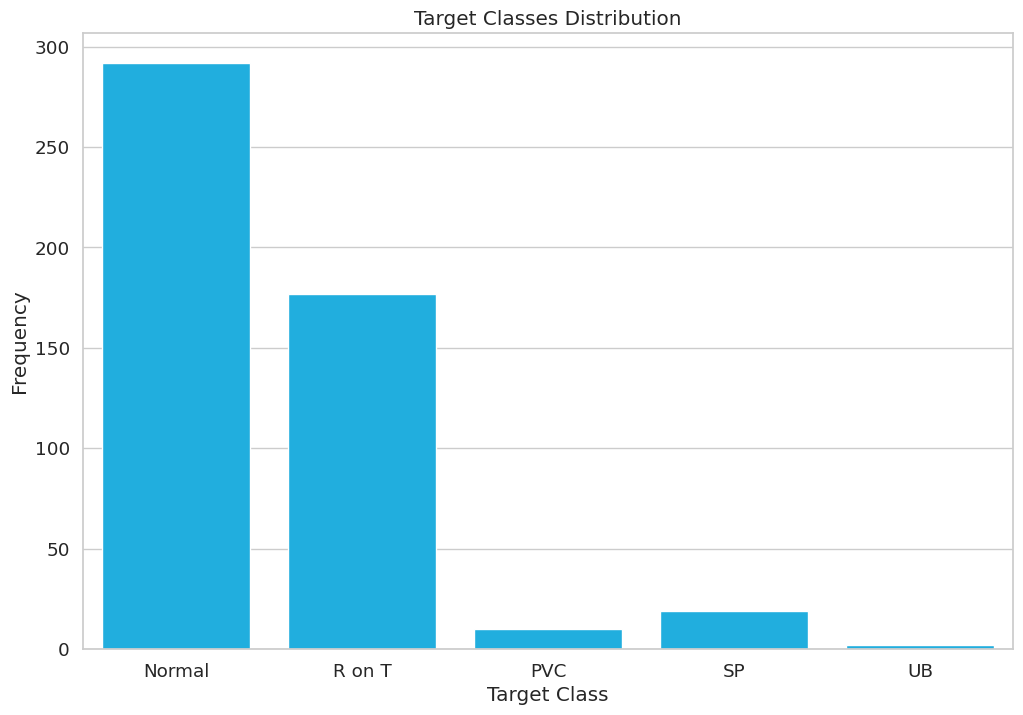

In [58]:


# Create the countplot
ax = sns.countplot(x='target', data=df_train)

# Set the x-axis labels to the class names
ax.set_xticklabels(class_names)

# Optional: Add title and labels
ax.set_title('Target Classes Distribution')
ax.set_xlabel('Target Class')
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

In [30]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

Averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

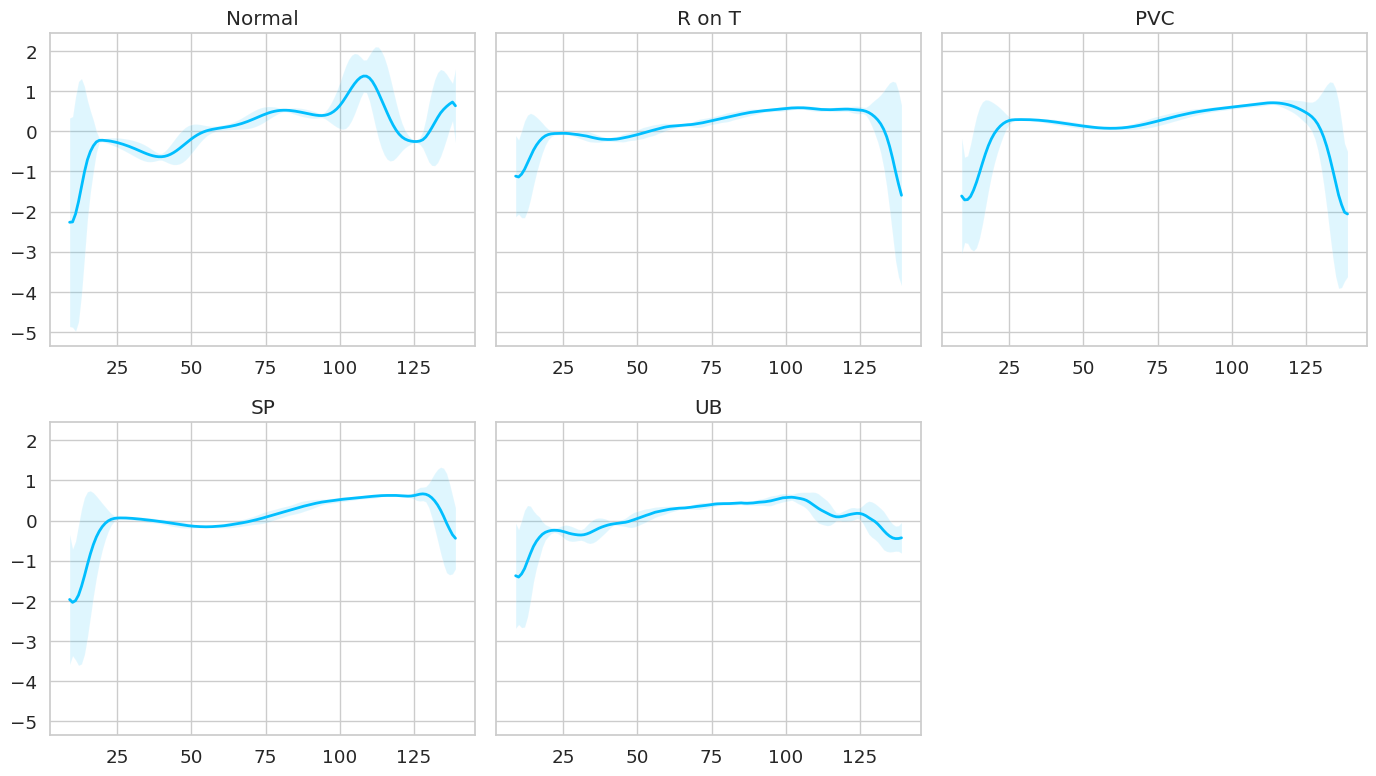

In [60]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

Dataset for Normal Heartbeats

In [31]:
normal_df = df[df.target == 1].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

Dataset for Anomalous Heartbeats(Data which are not in normal class that is target!=1)

In [32]:
anomaly_df = df[df.target != 1].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

In [33]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [34]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

In [35]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

LSTM AUTOENCODER

In [10]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

In [11]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [7]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [3]:
device='gpu'

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

Training model

In [42]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [78]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=50
)

Epoch 1: train loss 12.973018241668603 val loss 15.460693393551042
Epoch 2: train loss 12.751070240917151 val loss 11.737233067535296
Epoch 3: train loss 12.7741273417198 val loss 12.000314496076149
Epoch 4: train loss 13.024037572944515 val loss 11.717105922438586
Epoch 5: train loss 12.035936428817324 val loss 11.053097000707945
Epoch 6: train loss 12.149222286705623 val loss 12.385961513063606
Epoch 7: train loss 11.996907121757499 val loss 12.358250269710814
Epoch 8: train loss 11.88602164155867 val loss 11.604845051879362
Epoch 9: train loss 12.264925269626985 val loss 11.74916719657976
Epoch 10: train loss 11.985379334756896 val loss 11.628465045434217
Epoch 11: train loss 11.586698773694298 val loss 11.786456858338756
Epoch 12: train loss 12.773045376297544 val loss 11.407069738407591
Epoch 13: train loss 12.337021582071841 val loss 13.983955103382723
Epoch 14: train loss 12.019334255712064 val loss 11.345796083834392
Epoch 15: train loss 11.168214607123453 val loss 11.473216027

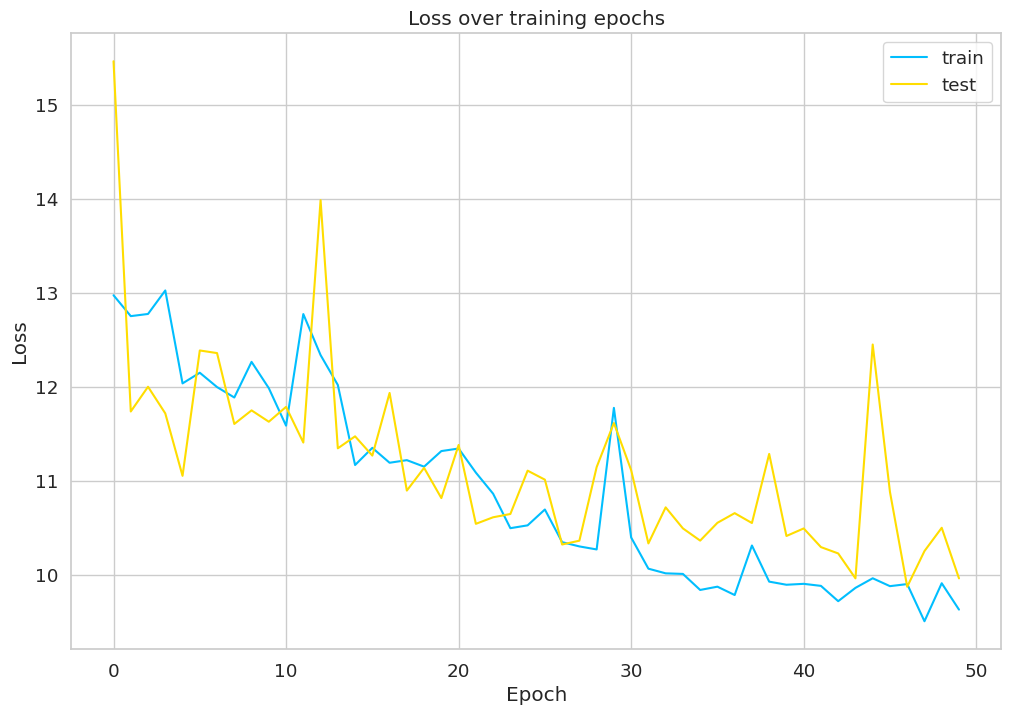

In [79]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()


In [80]:
MODEL_PATH = 'ecg_model1.pth'

torch.save(model, MODEL_PATH)

In [81]:
model, history = train_model(
  model,
  train_dataset,
  val_dataset,
  n_epochs=100
)

Epoch 1: train loss 10.212176331393616 val loss 10.646233753946454
Epoch 2: train loss 9.677039006120589 val loss 10.209962273620501
Epoch 3: train loss 10.056689890292997 val loss 10.317529880146118
Epoch 4: train loss 9.708346521599742 val loss 10.44688421874323
Epoch 5: train loss 9.948123815606458 val loss 10.073179070860046
Epoch 6: train loss 9.812616865272629 val loss 21.516536426218703
Epoch 7: train loss 14.55227564420012 val loss 12.834223996250296
Epoch 8: train loss 11.680859526719166 val loss 11.506921587543683
Epoch 9: train loss 10.622191240017763 val loss 11.375310058072973
Epoch 10: train loss 10.08886373316939 val loss 11.152688763654274
Epoch 11: train loss 12.224871253928846 val loss 12.468936137371909
Epoch 12: train loss 10.580742838881468 val loss 10.800790252945935
Epoch 13: train loss 10.06797940324555 val loss 10.910560301953208
Epoch 14: train loss 10.644923332380412 val loss 10.966249153475713
Epoch 15: train loss 10.158252324754315 val loss 9.96081629710799

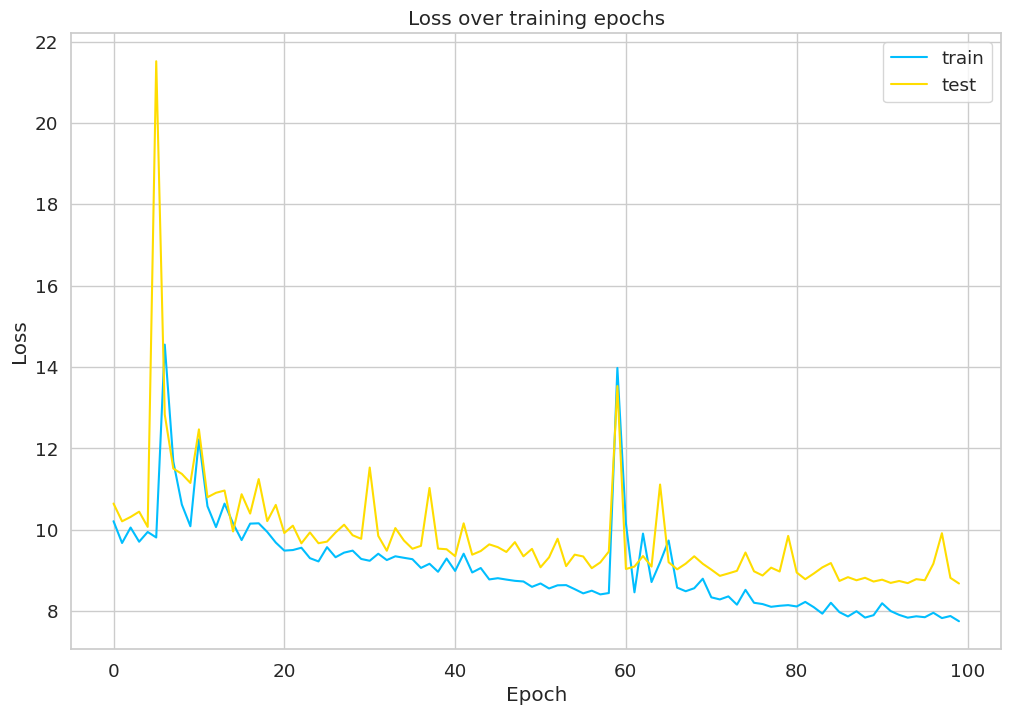

In [82]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show()

In [83]:
MODEL_PATH = '\content\driveecg_model2.pth'

torch.save(model, MODEL_PATH)

In [45]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

<ipython-input-46-84d7a7326ee0>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(losses, bins=50, kde=True)


<Axes: ylabel='Density'>

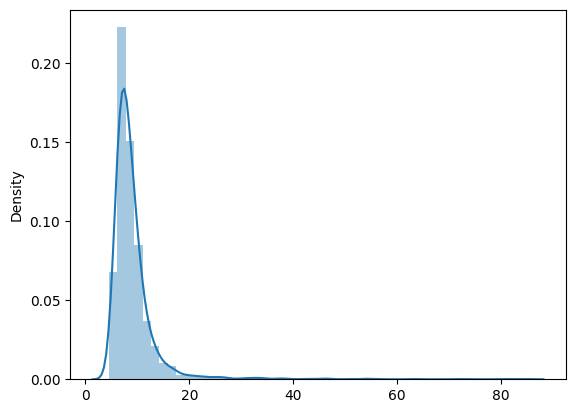

In [46]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True)

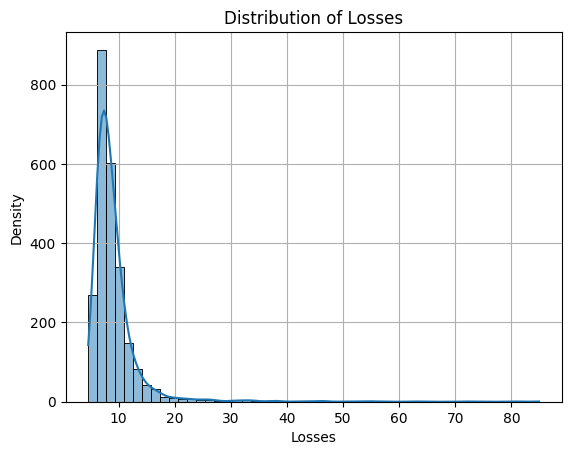

In [47]:
sns.histplot(losses, bins=50, kde=True)

# Add grid
plt.grid(True)

# Optional: Add labels and title
plt.xlabel('Losses')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Show the plot
plt.show()

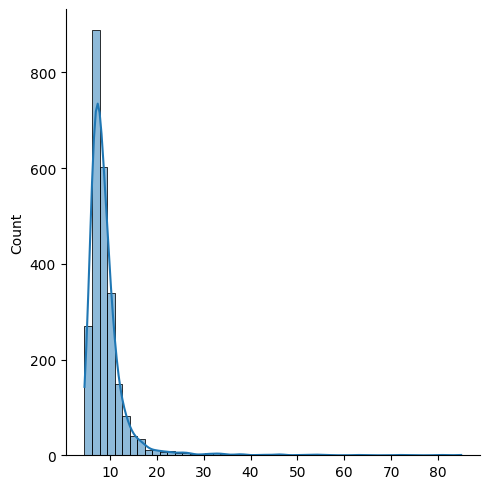

In [48]:
sns.displot(losses, bins=50, kde=True)

A threshold value for reconstruction loss is chosen such that if the reconstruction loss for the test data is below that value it is declared normal and if the reconstruction loss is over the value it is declared as anomalous.

In [49]:
THRESHOLD = 26

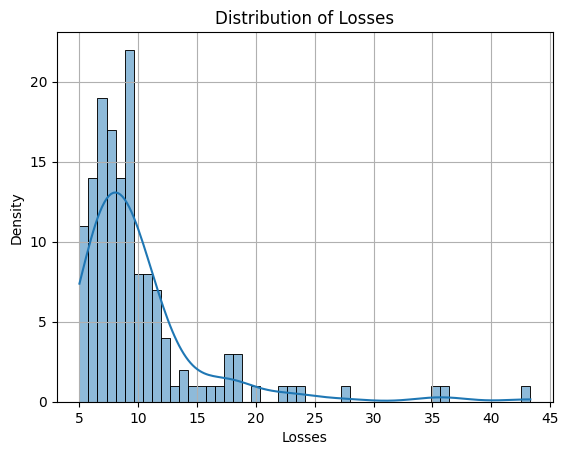

In [50]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.histplot(pred_losses, bins=50, kde=True)
# Add grid
plt.grid(True)

# Optional: Add labels and title
plt.xlabel('Losses')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Show the plot
plt.show()

In [51]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 141/145


In [52]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

In [53]:
predictions, pred_losses = predict(model, anomaly_dataset)

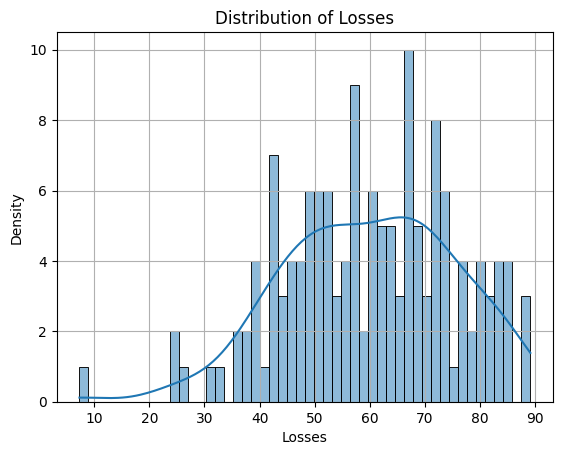

In [54]:
sns.histplot(pred_losses, bins=50, kde=True)
# Add grid
plt.grid(True)

# Optional: Add labels and title
plt.xlabel('Losses')
plt.ylabel('Density')
plt.title('Distribution of Losses')

# Show the plot
plt.show()

In [55]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

Correct anomaly predictions: 141/145


In [56]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

Comparison between true and reconstructed data

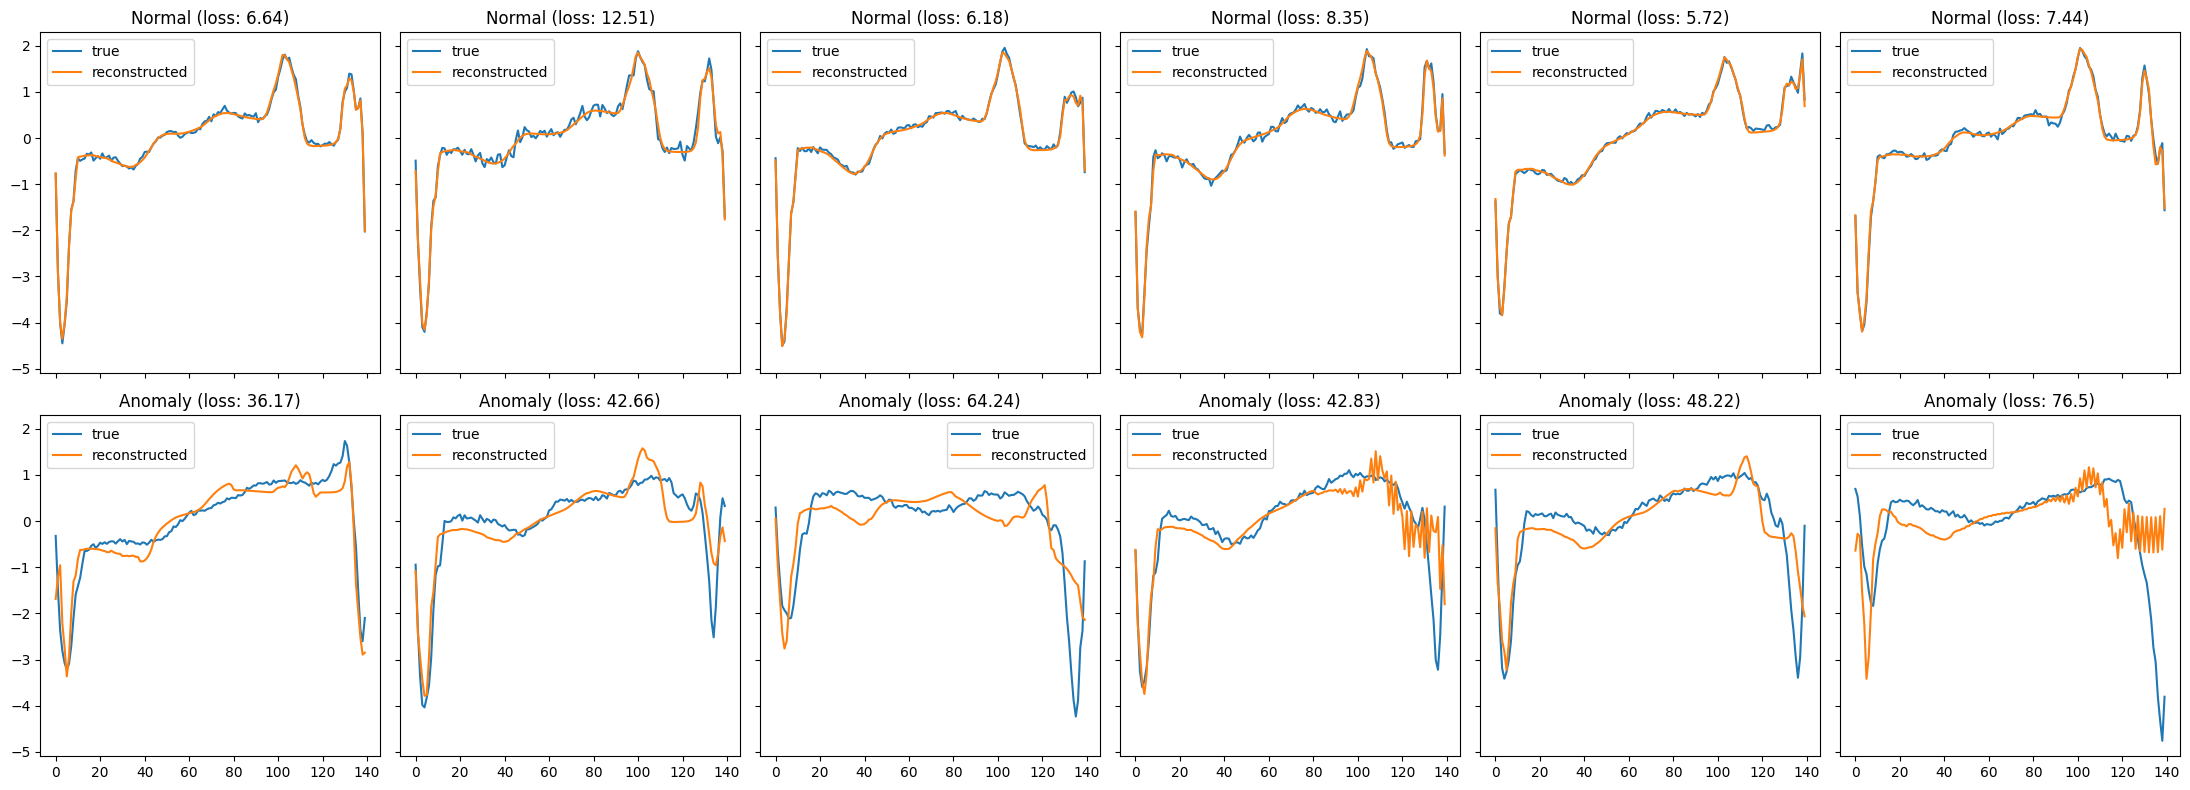

In [57]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()